In [1]:
import os
import sys
import re
from pathlib import Path
from pprint import pprint

# Set up Project Root
NOTEBOOK_DIR = Path().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print('Project:', PROJECT_ROOT)


Project: C:\Users\81803\Documents\フレア\kyoto-flare-detection


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Import star modules from src
try:
    from src import flarepy_EK_Dra as ek_module
    from src import flarepy_V889_Her as v889_module
    from src import flarepy_DS_Tuc_A as ds_module
    print("Successfully imported star modules from src.")
except ImportError as e:
    print(f"Error importing modules from src: {e}")
    # Fallback if src is not reachable as package (though logic above ensures it should be)
    import flarepy_EK_Dra as ek_module
    import flarepy_V889_Her as v889_module
    import flarepy_DS_Tuc_A as ds_module


Successfully imported star modules from src.


In [3]:
# =========================================================
# Star Configuration and Data Loading
# =========================================================
STAR_INFO = {
    "EKDra":    {"class": ek_module.FlareDetector_EK_Dra,   "label": "EK Dra"},
    "V889 Her": {"class": v889_module.FlareDetector_V889_Her, "label": "V889 Her"},
    "DS Tuc":   {"class": ds_module.FlareDetector_DS_Tuc_A,   "label": "DS Tuc"},
}

# Legacy compatibility
STAR_CLASS_MAP = {k: v['class'] for k, v in STAR_INFO.items()}

BASE_STARS_FOLDER = "C:/Users/81803/Documents/フレア/Kyoto_Student_Flare_Project/all_stars/"
all_stars_detectors = {}

print(f"Loading star data from: {BASE_STARS_FOLDER}")

if not os.path.exists(BASE_STARS_FOLDER):
    print(f"ERROR: Base folder not found!")
else:
    for star_folder_name in os.listdir(BASE_STARS_FOLDER):
        star_folder_path = os.path.join(BASE_STARS_FOLDER, star_folder_name)
        if not os.path.isdir(star_folder_path):
            continue
        if star_folder_name not in STAR_INFO:
            print(f"Skipping folder: {star_folder_name}")
            continue

        TargetClass = STAR_INFO[star_folder_name]["class"]
        star_label = STAR_INFO[star_folder_name]["label"]
        print(f"Processing: {star_label}")

        star_detectors = {}
        for fname in os.listdir(star_folder_path):
            if not fname.endswith(".fits"):
                continue
            file_path = os.path.join(star_folder_path, fname)
            s_number = None
            for part in fname.split("-"):
                if part.startswith("s") and len(part) >= 5 and part[1:5].isdigit():
                    s_number = part[:5]
                    break
            if s_number:
                try:
                    det = TargetClass(file=file_path, process_data=True, ene_thres_low=5e33, ene_thres_high=1e39)
                    if hasattr(det, 'tessBJD') and det.tessBJD is not None and len(det.tessBJD) > 0:
                        star_detectors[f"detector_{s_number}"] = det
                except Exception as e:
                    print(f"  Error: {fname}: {e}")

        if star_detectors:
            sorted_dets = dict(sorted(star_detectors.items(), key=lambda x: x[1].tessBJD[0] if x[1].tessBJD is not None and len(x[1].tessBJD) > 0 else float('inf')))
            all_stars_detectors[star_label] = sorted_dets
            print(f"  Loaded {len(sorted_dets)} sectors")

print(f"\nTotal stars loaded: {len(all_stars_detectors)}")
print(f"Stars: {list(all_stars_detectors.keys())}")


Loading star data from: C:/Users/81803/Documents/フレア/Kyoto_Student_Flare_Project/all_stars/
Processing: DS Tuc
  Loaded 5 sectors
Processing: EK Dra
  Loaded 12 sectors
Processing: V889 Her
  Loaded 4 sectors

Total stars loaded: 3
Stars: ['DS Tuc', 'EK Dra', 'V889 Her']


In [4]:
print("\n--- DEBUG INFO: Checking Attributes ---")
if 'all_stars_detectors' in locals() and all_stars_detectors:
    try:
        # 辞書から最初の星の名前を取得
        first_star_name = next(iter(all_stars_detectors))
        first_star_detectors = all_stars_detectors[first_star_name]
        
        if first_star_detectors:
            # その星の最初のインスタンスを取得
            first_instance = next(iter(first_star_detectors.values()))
            print(f"List of attributes for one instance of star '{first_star_name}':")
            
            # インスタンスが持つ全ての属性名と、その中身（最初の50文字）を表示
            for attr in dir(first_instance):
                if not attr.startswith('__'): # 特殊な属性は無視
                    try:
                        value = getattr(first_instance, attr)
                        print(f"  - {attr}: {str(value)[:50]}") # 値を少しだけ表示
                    except Exception:
                        print(f"  - {attr}: (Could not get value)")

    except StopIteration:
        print("Could not find any stars or detectors to debug.")
    except Exception as e:
        print(f"An error occurred during debugging: {e}")
print("--- END DEBUG INFO ---\n")


--- DEBUG INFO: Checking Attributes ---
List of attributes for one instance of star 'DS Tuc':
  - R_sunstar_ratio: 0.87
  - T_star: 5428
  - _get_star_intensity_ratio: <bound method BaseFlareDetector._get_star_intensit
  - _get_tess_response: <function BaseFlareDetector._get_tess_response at 
  - a_i: [ 0.02714841  0.06758904 -0.02476304  0.03827366  
  - amPDCSAPflux: [0.9781133  0.97864376 0.9774506  ... 0.9845172  0
  - amPDCSAPfluxerr: [0.00038245 0.0003826  0.00038241 ... 0.00038312 0
  - apply_gap_correction: <bound method BaseFlareDetector.apply_gap_correcti
  - array_amplitude: [0.05573314 0.0812002  0.06324531 0.04163891 0.053
  - array_data_name: ['tess2018206045859-s0001' 'tess2020186164531-s002
  - array_energy_ratio: [4.57160380e+33 1.27069468e+34 1.15749303e+34 7.46
  - array_flare_ratio: [0.23946785 0.39052613 0.47549861 0.19257773 0.378
  - array_observation_time: [1338.1120237  2047.94839629 2072.52695069 3140.60
  - array_per: [2.85227313 3.63302752 3.5254297  3.0140

In [5]:
print("available keys:", list(all_stars_detectors.keys()))


available keys: ['DS Tuc', 'EK Dra', 'V889 Her']


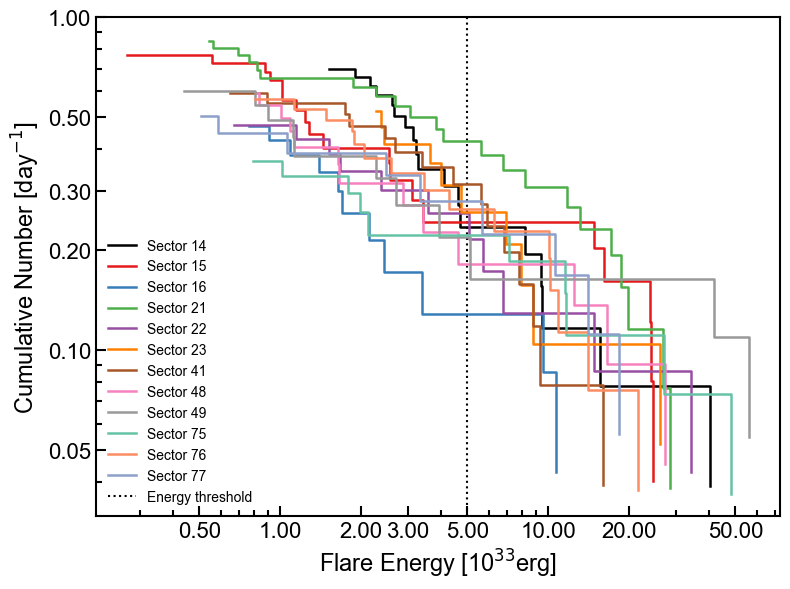

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ===============================
# 論文用スタイル設定（そのまま流用）
# ===============================
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# ===============================
# データ取得
# ===============================
# values() だけだと sector 情報（detector_sXXXX）が失われるので items() を使う
detector_items = list(all_stars_detectors["EK Dra"].items())  # (detector_s0001, instance) のリスト

colors = [
    "#000000", "#E41A1C", "#377EB8", "#4DAF4A",
    "#984EA3", "#FF7F00", "#A65628", "#F781BF",
    "#999999", "#66C2A5", "#FC8D62", "#8DA0CB",
]

# ===============================
# Figure 作成
# ===============================
fig, ax = plt.subplots(figsize=(8, 6))

# ===============================
# 各インスタンスを描画
# ===============================
for i, (det_name, det) in enumerate(detector_items):
    if det.energy is None or len(det.energy) == 0:
        continue

    color = colors[i % len(colors)]

    energy_cor = np.sort(det.energy)
    cumenergy = np.array([len(energy_cor) - j for j in range(len(energy_cor))])
    rate = cumenergy / det.precise_obs_time

    # det_name は "detector_s0001" の想定 → "Sector 1" にする
    try:
        s = det_name.split("_")[-1]      # "s0001"
        sector_num = int(s[1:])          # 1
        label = f"Sector {sector_num}"
    except Exception:
        # 万一想定外の名前でも落ちないように保険
        label = det_name

    ax.step(
        energy_cor / 1e33,
        rate,
        where="post",
        color=color,
        linewidth=1.8,
        label=label,   # ←ここが Sector 表示
    )

# ===============================
# 軸設定（論文向け）
# ===============================
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Flare Energy [10$^{33}$erg]", fontsize=17)
ax.set_ylabel(r"Cumulative Number [day$^{-1}$]", fontsize=17)

ax.tick_params(labelsize=16)

ax.axvline(
    x=5,
    color="black",
    linestyle="dotted",
    linewidth=1.5,
    label="Energy threshold",
    zorder=0
)

ax.set_xticks([0.5, 1.0, 2.0, 3.0, 5.0, 10.0, 20.0, 50.0])
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
ax.xaxis.set_minor_formatter(mticker.NullFormatter())

ax.set_yticks([0.05, 0.1, 0.2, 0.3, 0.5, 1])
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

# ===============================
# Legend（枠なし）
# ===============================
leg = ax.legend(
    loc="lower left",
    fontsize=10,
    frameon=True,
)
leg.get_frame().set_alpha(0)

# ===============================
# 保存・表示
# ===============================
plt.tight_layout()
plt.savefig("flare_cumenergy_EKDra.pdf", format="pdf", bbox_inches="tight")
plt.show()


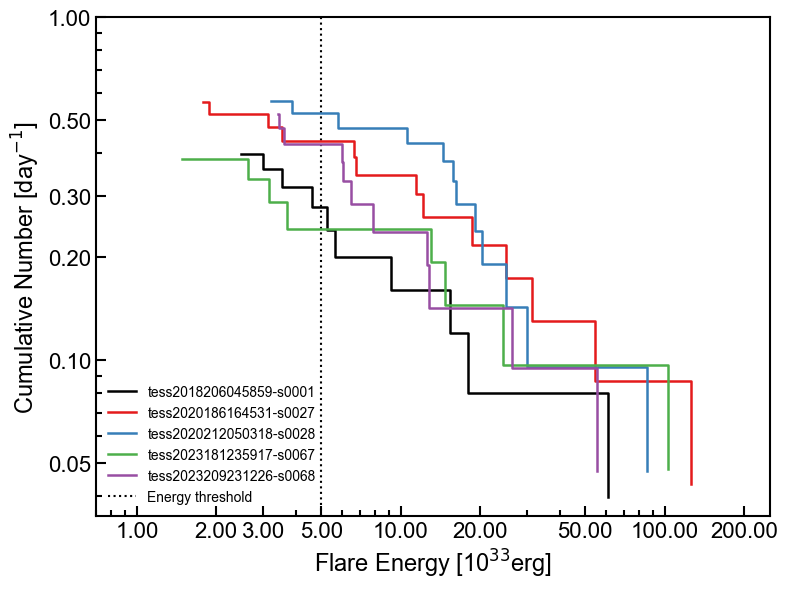

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ===============================
# 論文用スタイル設定（そのまま流用）
# ===============================
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# ===============================
# データ取得
# ===============================
detector_list = list(all_stars_detectors["DS Tuc"].values())

colors = [
    "#000000", "#E41A1C", "#377EB8", "#4DAF4A",
    "#984EA3"
]

# ===============================
# Figure 作成
# ===============================
fig, ax = plt.subplots(figsize=(8, 6))

# ===============================
# 各インスタンスを描画
# ===============================
for i, det in enumerate(detector_list):
    if det.energy is None or len(det.energy) == 0:
        continue

    color = colors[i % len(colors)]

    energy_cor = np.sort(det.energy)
    cumenergy = np.array([len(energy_cor) - j for j in range(len(energy_cor))])
    rate = cumenergy / det.precise_obs_time

    ax.step(
        energy_cor/1e33,
        rate,
        where="post",
        color=color,
        linewidth=1.8,
        label=det.data_name,
    )

# ===============================
# 軸設定（論文向け）
# ===============================
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Flare Energy [10$^{33}$erg]", fontsize=17)
ax.set_ylabel(r"Cumulative Number [day$^{-1}$]", fontsize=17)

ax.tick_params(labelsize=16)

ax.axvline(
    x=5,
    color="black",
    linestyle="dotted",
    linewidth=1.5,
    label="Energy threshold",
    zorder=0
)


ax.set_xticks([1.0, 2.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100, 200])
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
# X軸の補助目盛りが指数表示になるのを防ぐ（任意）
ax.xaxis.set_minor_formatter(mticker.NullFormatter())

ax.set_yticks([0.05 , 0.1 , 0.2 , 0.3 , 0.5 , 1 ])
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

ax.set_xlim(0.7, 250)


# ===============================
# Legend（枠なし）
# ===============================
leg = ax.legend(
    loc="lower left",
    fontsize=10,
    frameon=True,
)
leg.get_frame().set_alpha(0)

# ===============================
# 保存・表示
# ===============================
plt.tight_layout()
plt.savefig("flare_cumenergy_DSTuc.pdf", format="pdf", bbox_inches="tight")
plt.show()


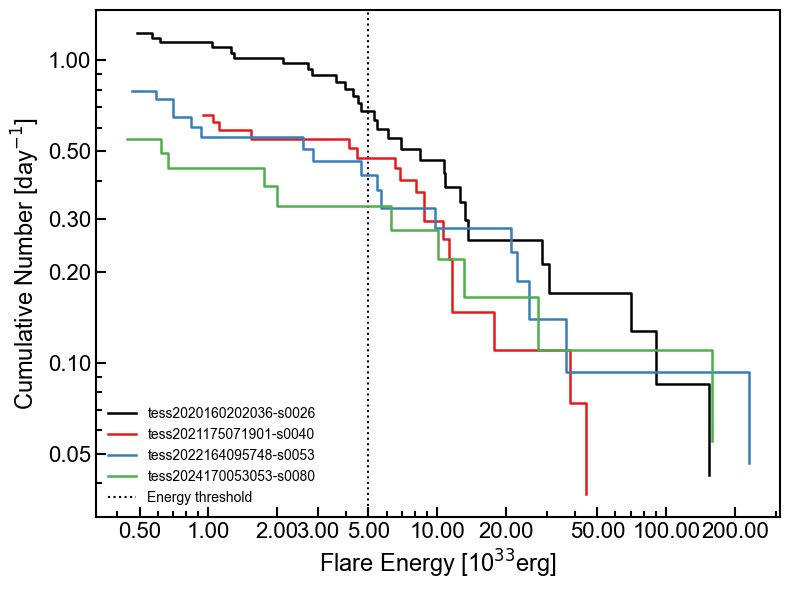

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ===============================
# 論文用スタイル設定（そのまま流用）
# ===============================
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# ===============================
# データ取得
# ===============================
detector_list = list(all_stars_detectors["V889 Her"].values())

colors = [
    "#000000", "#E41A1C", "#377EB8", "#4DAF4A"
]

# ===============================
# Figure 作成
# ===============================
fig, ax = plt.subplots(figsize=(8, 6))

# ===============================
# 各インスタンスを描画
# ===============================
for i, det in enumerate(detector_list):
    if det.energy is None or len(det.energy) == 0:
        continue

    color = colors[i % len(colors)]

    energy_cor = np.sort(det.energy)
    cumenergy = np.array([len(energy_cor) - j for j in range(len(energy_cor))])
    rate = cumenergy / det.precise_obs_time

    ax.step(
        energy_cor/1e33,
        rate,
        where="post",
        color=color,
        linewidth=1.8,
        label=det.data_name,
    )

# ===============================
# 軸設定（論文向け）
# ===============================
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Flare Energy [10$^{33}$erg]", fontsize=17)
ax.set_ylabel(r"Cumulative Number [day$^{-1}$]", fontsize=17)

ax.tick_params(labelsize=16)

ax.axvline(
    x=5,
    color="black",
    linestyle="dotted",
    linewidth=1.5,
    label="Energy threshold",
    zorder=0
)


ax.set_xticks([0.5, 1.0, 2.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100, 200])
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
# X軸の補助目盛りが指数表示になるのを防ぐ（任意）
ax.xaxis.set_minor_formatter(mticker.NullFormatter())

ax.set_yticks([0.05 , 0.1 , 0.2 , 0.3 , 0.5 , 1 ])
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

# ===============================
# Legend（枠なし）
# ===============================
leg = ax.legend(
    loc="lower left",
    fontsize=10,
    frameon=True,
)
leg.get_frame().set_alpha(0)

# ===============================
# 保存・表示
# ===============================
plt.tight_layout()
plt.savefig("flare_cumenergy_V889Her.pdf", format="pdf", bbox_inches="tight")
plt.show()


DS Tuc: a = 2.40e-01, b = 0.38
EK Dra: a = 2.40e-01, b = 0.38
V889 Her: a = 2.40e-01, b = 0.38


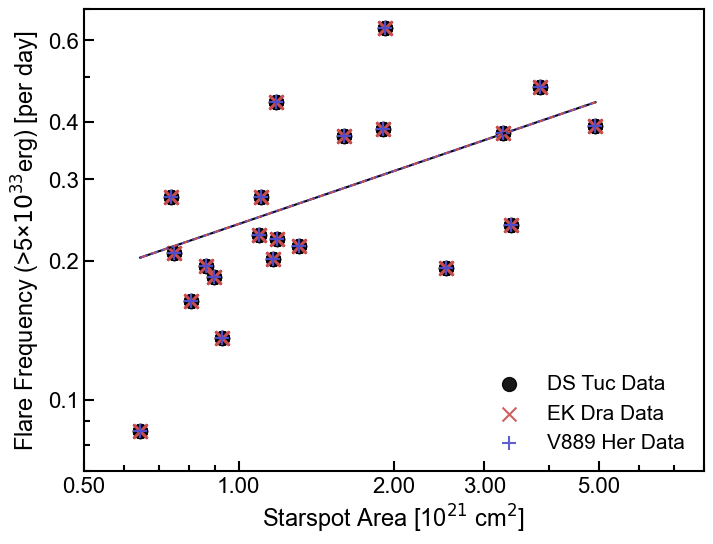

In [ ]:
import matplotlib.ticker as mticker
from scipy.optimize import curve_fit

# --- 論文用のスタイル設定 ---
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16

x_axis_attribute = 'array_starspot'
y_axis_attribute = 'array_flare_ratio'

fig, ax = plt.subplots(figsize=(8, 6))
plot_successful = False

if 'all_stars_detectors' in locals() and all_stars_detectors:
    color_map = {'DS Tuc': 'black', 'EK Dra': (0.8, 0.3, 0.3), 'V889 Her': (0.3, 0.3, 0.8)}
    marker_map = {'DS Tuc': 'o', 'EK Dra': 'x', 'V889 Her': '+'}
    linestyle_map = {'DS Tuc': '-', 'EK Dra': '--', 'V889 Her': ':'}
    marker_size = 100

    for star_name, detectors_dict in all_stars_detectors.items():
        x_data_for_star = []
        y_data_for_star = []
        for det_instance in detectors_dict.values():
            if hasattr(det_instance, x_axis_attribute) and hasattr(det_instance, y_axis_attribute):
                x = getattr(det_instance, x_axis_attribute)
                y = getattr(det_instance, y_axis_attribute)
                if isinstance(x, (list, np.ndarray)) and len(x) > 0 and len(x) == len(y):
                    x_data_for_star.extend(x)
                    y_data_for_star.extend(y)

        if len(x_data_for_star) > 1:
            x_data = np.array(x_data_for_star)
            y_data = np.array(y_data_for_star)
            x_data_scaled = x_data / 1e17
            
            current_color = color_map.get(star_name, 'grey')
            current_marker = marker_map.get(star_name, 'x')
            
            ax.scatter(x_data_scaled, y_data, label=f'{star_name} Data', color=current_color, alpha=0.9, marker=current_marker, s=marker_size)

            # Power law fitting - INSIDE the data-check if block
            def power_law(x, a, b):
                return a * x**b

            try:
                mask = (x_data_scaled > 0) & (y_data > 0)
                if len(x_data_scaled[mask]) > 1:
                    popt, pcov = curve_fit(power_law, x_data_scaled[mask], y_data[mask])
                    a, b = popt
                    x_fit = np.linspace(x_data_scaled[mask].min(), x_data_scaled[mask].max(), 200)
                    ax.plot(x_fit, power_law(x_fit, a, b), color=current_color, linestyle=linestyle_map.get(star_name, '-'))
                    print(f'{star_name}: a = {a:.2e}, b = {b:.2f}')
                    plot_successful = True
            except Exception as e:
                print(f'Fit error for {star_name}: {e}')

    if plot_successful:
        ax.set_xlabel(r'Starspot Area [10$^{21}$ cm$^2$]', fontsize=17)
        ax.set_ylabel('Flare Frequency (>5×$10^{33}$erg) [per day]', fontsize=17)
        ax.set_yscale('log'); ax.set_xscale('log')
        ax.set_xlim(0.5, 8); ax.set_ylim(0.07, 0.7)
        ax.set_xticks([0.5, 1.0, 2.0, 3.0, 5.0])
        ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
        ax.set_yticks([0.1 , 0.2 , 0.3 ,0.4 , 0.6 ])
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
        ax.legend(loc='lower right', frameon=False, fontsize=15)
        plt.savefig('analysis_result_freq_plot.pdf', format='pdf', bbox_inches='tight')
        plt.show()


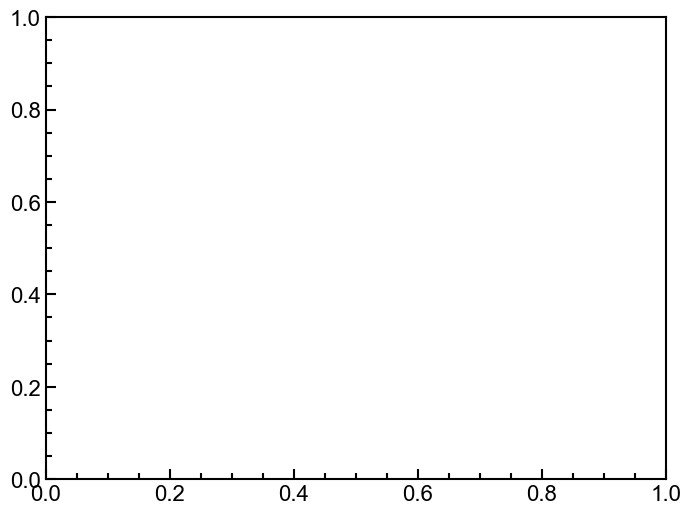

In [10]:
import matplotlib.ticker as mticker
from scipy.optimize import curve_fit

x_axis_attribute = 'array_starspot'
y_axis_attribute = 'array_sum_energy'

fig, ax = plt.subplots(figsize=(8, 6))
plot_successful = False

if 'all_stars_detectors' in locals() and all_stars_detectors:
    color_map = {'DS Tuc': 'black', 'EK Dra': (0.8, 0.3, 0.3), 'V889 Her': (0.3, 0.3, 0.8)}
    marker_map = {'DS Tuc': 'o', 'EK Dra': 'x', 'V889 Her': '+'}
    linestyle_map = {'DS Tuc': '-', 'EK Dra': '--', 'V889 Her': ':'}
    marker_size = 100

    for star_name, detectors_dict in all_stars_detectors.items():
        x_data_for_star, y_data_for_star = [], []
        for det in detectors_dict.values():
            if hasattr(det, x_axis_attribute) and hasattr(det, y_axis_attribute):
                x, y = getattr(det, x_axis_attribute), getattr(det, y_axis_attribute)
                if isinstance(x, (list, np.ndarray)) and len(x) == len(y):
                    x_data_for_star.extend(x)
                    y_data_for_star.extend(y)

        if len(x_data_for_star) > 1:
            x_scaled = np.array(x_data_for_star) / 1e17
            y_scaled = np.array(y_data_for_star) / 1e35
            current_color = color_map.get(star_name, 'grey')
            ax.scatter(x_scaled, y_scaled, label=f'{star_name} Data', color=current_color, alpha=0.9, marker=marker_map.get(star_name, 'x'), s=marker_size)

            def power_law(x, a, b): return a * x**b
            try:
                mask = (x_scaled > 0) & (y_scaled > 0)
                if len(x_scaled[mask]) > 1:
                    popt, _ = curve_fit(power_law, x_scaled[mask], y_scaled[mask])
                    x_fit = np.linspace(x_scaled[mask].min(), x_scaled[mask].max(), 200)
                    ax.plot(x_fit, power_law(x_fit, *popt), color=current_color, linestyle=linestyle_map.get(star_name, '-'))
                    plot_successful = True
            except Exception as e: print(f'Fit error for {star_name}: {e}')

    if plot_successful:
        ax.set_xlabel(r'Starspot Area [10$^{21}$ cm$^2$]', fontsize=17)
        ax.set_ylabel('Total Flare Energy [10$^{35}$ erg]', fontsize=17)
        ax.set_yscale('log'); ax.set_xscale('log')
        ax.set_xlim(0.5, 8); ax.set_ylim(0.1, 7)
        ax.set_xticks([0.5, 1.0, 2.0, 3.0, 5.0]); ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
        ax.set_yticks([0.1, 0.2, 0.3, 0.5, 1.0, 2.0, 3.0]); ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
        ax.legend(loc='lower right', frameon=False, fontsize=15)
        plt.savefig('analysis_result_total_plot.pdf', format='pdf', bbox_inches='tight')
        plt.show()


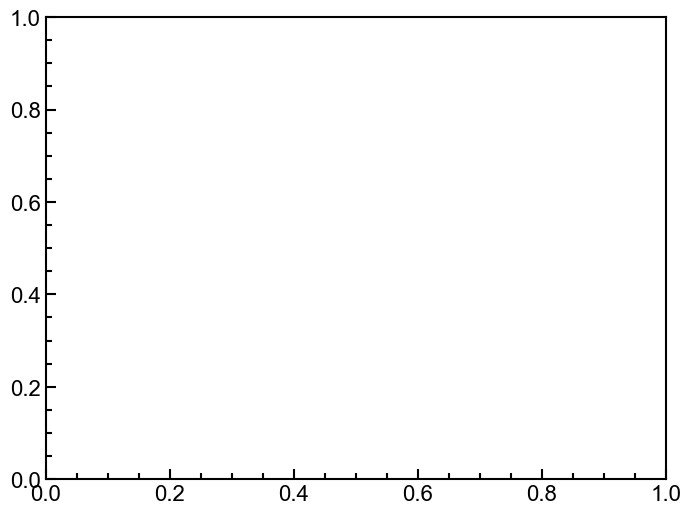

In [11]:
import matplotlib.ticker as mticker
from scipy.stats import pearsonr

x_axis_attribute = 'array_starspot'
y_axis_attribute = 'array_max_energy'

fig, ax = plt.subplots(figsize=(8, 6))
plot_successful = False

if 'all_stars_detectors' in locals() and all_stars_detectors:
    color_map = {'DS Tuc': 'black', 'EK Dra': (0.8, 0.3, 0.3), 'V889 Her': (0.3, 0.3, 0.8)}
    marker_map = {'DS Tuc': 'o', 'EK Dra': 'x', 'V889 Her': '+'}
    marker_size = 100

    for star_name, detectors_dict in all_stars_detectors.items():
        x_data_for_star, y_data_for_star = [], []
        for det in detectors_dict.values():
            if hasattr(det, x_axis_attribute) and hasattr(det, y_axis_attribute):
                x, y = getattr(det, x_axis_attribute), getattr(det, y_axis_attribute)
                if isinstance(x, (list, np.ndarray)) and len(x) == len(y):
                    x_data_for_star.extend(x)
                    y_data_for_star.extend(y)

        if len(x_data_for_star) > 1:
            x_scaled = np.array(x_data_for_star) / 1e17
            y_scaled = np.array(y_data_for_star) / 1e34
            
            r_str, p_str = 'NA', 'NA'
            if len(x_scaled) > 1 and np.nanstd(x_scaled) > 0 and np.nanstd(y_scaled) > 0:
                r, p = pearsonr(x_scaled, y_scaled)
                r_str, p_str = f'{r:.2f}', f'{p:.2e}'
            
            label = f'{star_name} (r={r_str}, p={p_str}, N={len(x_scaled)})'
            current_color = color_map.get(star_name, 'grey')
            ax.scatter(x_scaled, y_scaled, label=label, color=current_color,
                       alpha=0.9, marker=marker_map.get(star_name, 'x'), s=marker_size)
            plot_successful = True

    if plot_successful:
        ax.set_xlabel(r'Starspot Area [10$^{21}$ cm$^2$]', fontsize=17)
        ax.set_ylabel('Max Flare Energy [10$^{34}$ erg]', fontsize=17)
        ax.set_yscale('log'); ax.set_xscale('log')
        ax.set_xlim(0.5, 8); ax.set_ylim(0.5, 45)
        ax.set_xticks([0.5, 1.0, 2.0, 3.0, 5.0]); ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
        ax.set_yticks([0.5, 1.0, 2.0, 3.0, 5.0, 10.0, 20.0]); ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
        ax.legend(loc='lower right', frameon=False, fontsize=12)
        plt.savefig('analysis_result_maxene_plot.pdf', format='pdf', bbox_inches='tight')
        plt.show()
